### Error Propagation by Bootstrapping

Bootstrap iteration 1 out of 25 completed.
Bootstrap iteration 2 out of 25 completed.
Bootstrap iteration 3 out of 25 completed.
Bootstrap iteration 4 out of 25 completed.
Bootstrap iteration 5 out of 25 completed.
Bootstrap iteration 6 out of 25 completed.
Bootstrap iteration 7 out of 25 completed.
Bootstrap iteration 8 out of 25 completed.
Bootstrap iteration 9 out of 25 completed.
Bootstrap iteration 10 out of 25 completed.
Bootstrap iteration 11 out of 25 completed.
Bootstrap iteration 12 out of 25 completed.
Bootstrap iteration 13 out of 25 completed.
Bootstrap iteration 14 out of 25 completed.
Bootstrap iteration 15 out of 25 completed.
Bootstrap iteration 16 out of 25 completed.
Bootstrap iteration 17 out of 25 completed.
Bootstrap iteration 18 out of 25 completed.
Bootstrap iteration 19 out of 25 completed.
Bootstrap iteration 20 out of 25 completed.
Bootstrap iteration 21 out of 25 completed.
Bootstrap iteration 22 out of 25 completed.
Bootstrap iteration 23 out of 25 complete

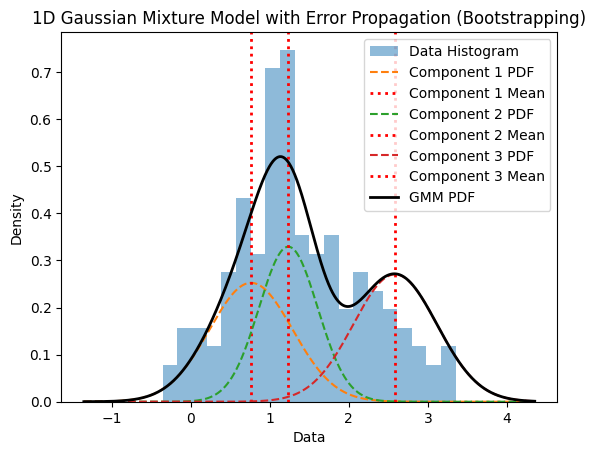

In [6]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from joblib import Parallel, delayed
import pyco2stats as PyCO2

# Define the function to apply constraints
def apply_constraints(means, stds, weights, mean_constraints, std_constraints):
    n_components = len(means)
    with torch.no_grad():
        for i in range(n_components):
            means[i].clamp_(mean_constraints[i][0], mean_constraints[i][1])
            stds[i].clamp_(std_constraints[i][0], std_constraints[i][1])
        weights.clamp_(min=0)
        weights /= weights.sum()

# Define the training loop for a single bootstrap sample
def train_gmm_single_sample(data, mean_constraints, std_constraints, n_epochs=500):
    n_components = len(mean_constraints)
    means = torch.tensor([0.5, 1.0, 3.0], requires_grad=True)
    stds = torch.tensor([0.9, 0.5, 0.3], requires_grad=True)
    weights = torch.tensor([1/3, 1/3, 1/3], requires_grad=True)
    
    optimizer = torch.optim.Adam([means, stds, weights], lr=0.001)
    
    for epoch in range(n_epochs):
        optimizer.zero_grad()
        log_likelihood = 0
        for x in data:
            mixture_prob = 0
            for j in range(n_components):
                weight = weights[j]
                mean = means[j]
                std = stds[j]
                mixture_prob += weight * torch.exp(-0.5 * ((x - mean) / std) ** 2) / (std * np.sqrt(2 * np.pi))
            log_likelihood += torch.log(mixture_prob + 1e-10)

        loss = -log_likelihood.mean()
        
        loss.backward()
        optimizer.step()
        
        apply_constraints(means, stds, weights, mean_constraints, std_constraints)

    return means.detach().numpy(), stds.detach().numpy(), weights.detach().numpy()

# Function to perform a single bootstrap iteration
def bootstrap_iteration(i, X, mean_constraints, std_constraints):
    noisy_data = X + torch.randn(X.size()) * 0.1 * X  # Adding noise to simulate 10% uncertainty
    result = train_gmm_single_sample(noisy_data, mean_constraints, std_constraints)
    return result

import pandas as pd
my_dataset = pd.read_excel('PYTHONSS.xlsx')
my_dataset = my_dataset.dropna(subset=['A'])

if __name__ == "__main__":
    
    # Example 1D data (replace this with your actual 1D data)
    X = my_dataset.A

    # Convert the data to a PyTorch tensor
    X = torch.tensor(X, dtype=torch.float32)

    # Define constraints for each component
    mean_constraints = [(0.1, 2), (1, 3), (2, 4)]
    std_constraints = [(0.1, 2.5), (0.1, 2.5), (0.1, 2.5)]

    # Bootstrapping
    n_bootstrap_samples = 25

    results = []
    for i in range(n_bootstrap_samples):
        
        result = bootstrap_iteration(i, X, mean_constraints, std_constraints)
        results.append(result)
        
        # Print update every iteration
        if (i + 1) % 1 == 0 or i == n_bootstrap_samples - 1:
            print(f"Bootstrap iteration {i + 1} out of {n_bootstrap_samples} completed.")
    
    # Collect the results
    bootstrap_means, bootstrap_stds, bootstrap_weights = zip(*results)

    # Convert to numpy arrays for easier manipulation
    bootstrap_means = np.array(bootstrap_means)
    bootstrap_stds = np.array(bootstrap_stds)
    bootstrap_weights = np.array(bootstrap_weights)

    # Calculate the mean and standard deviation of the bootstrap results
    mean_means = np.mean(bootstrap_means, axis=0)
    std_means = np.std(bootstrap_means, axis=0)

    mean_stds = np.mean(bootstrap_stds, axis=0)
    std_stds = np.std(bootstrap_stds, axis=0)

    mean_weights = np.mean(bootstrap_weights, axis=0)
    std_weights = np.std(bootstrap_weights, axis=0)

    # Print the results
    print("\nBootstrap Results:")
    print("\nMeans:")
    print("Optimized Means:", mean_means)
    print("Standard Deviations of Means:", std_means)

    print("\nStandard Deviations:")
    print("Optimized Stds:", mean_stds)
    print("Standard Deviations of Stds:", std_stds)

    print("\nWeights:")
    print("Optimized Weights:", mean_weights)
    print("Standard Deviations of Weights:", std_weights)

    # Plot the bootstrap results
    x_values = np.linspace(X.min() - 1, X.max() + 1, 1000)

    # Plot the data histogram
    plt.hist(X.numpy(), bins=20, density=True, alpha=0.5, label='Data Histogram')

    # Plot each Gaussian component using the norm.pdf function with mean and std from bootstrap means
    for i in range(len(mean_constraints)):
        mean = mean_means[i]
        std_dev = mean_stds[i]
        weight = mean_weights[i]
        
        # Calculate the Gaussian component's PDF
        component_pdf = weight * norm.pdf(x_values, loc=mean, scale=std_dev)
        
        # Plot the component's PDF
        plt.plot(x_values, component_pdf, '--', label=f'Component {i + 1} PDF')
        plt.axvline(mean, color='red', linestyle=':', linewidth=2, label=f'Component {i + 1} Mean')

    # Plot the overall GMM PDF
    overall_pdf = np.sum([mean_weights[i] * norm.pdf(x_values, mean_means[i], mean_stds[i]) for i in range(len(mean_constraints))], axis=0)

    plt.plot(x_values, overall_pdf, '-k', label='GMM PDF', linewidth=2)

    # Add plot details
    plt.title('1D Gaussian Mixture Model with Error Propagation (Bootstrapping)')
    plt.xlabel('Data')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

### How to reconstruct a sample from a PDF (utile per il seguente P-P plot)

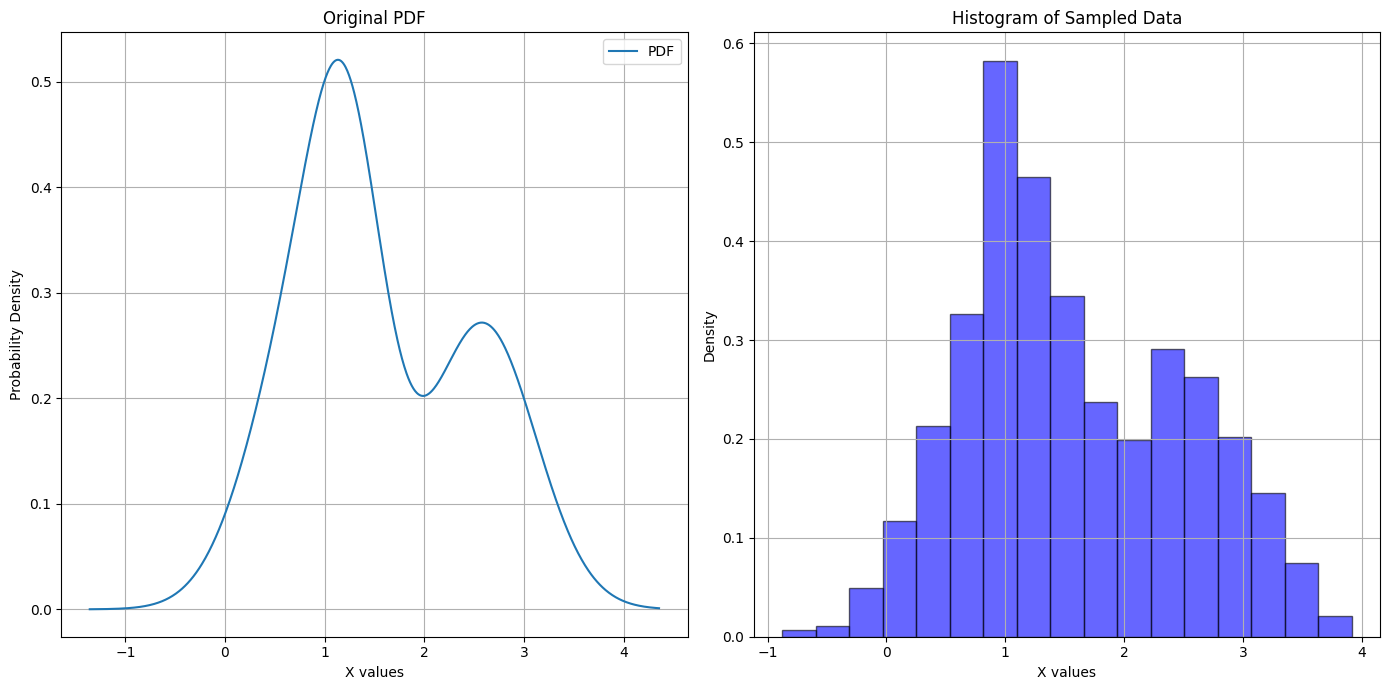

In [7]:
import numpy as np
import matplotlib.pyplot as plt


# Generate n samples from the PDF
sampled_data = PyCO2.Stats.sample_from_pdf(x_values, overall_pdf, n_samples=1000)

# Plot the original PDF and the histogram of the sampled data
plt.figure(figsize=(14, 7))

# Plot the original PDF
plt.subplot(1, 2, 1)
plt.plot(x_values, overall_pdf, label='PDF')
plt.title('Original PDF')
plt.xlabel('X values')
plt.ylabel('Probability Density')
plt.grid()
plt.legend()

# Plot the histogram of the sampled data
plt.subplot(1, 2, 2)
plt.hist(sampled_data, bins='auto', density=True, alpha=0.6, color='blue', edgecolor='black')
plt.title('Histogram of Sampled Data')
plt.xlabel('X values')
plt.ylabel('Density')
plt.grid()

plt.tight_layout()
plt.show()

### Percentile-Percentile plot (P-P plot) comparing the observed data with a custom distribution (da Verificare)

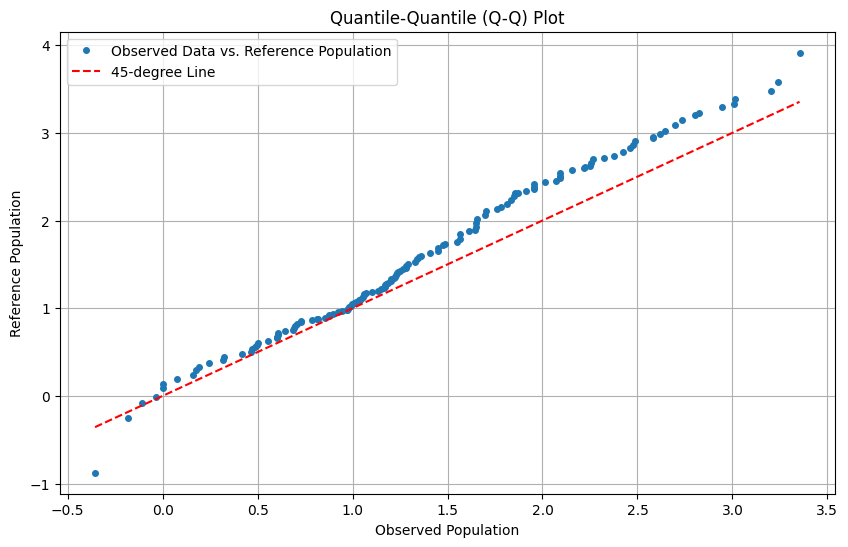

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Example observed data
observed_data = my_dataset.A

# Use identical data for reference population to test alignment
reference_population = sampled_data # if you put observed_data, data should lie in the 45 degree line


fig, ax = plt.subplots(figsize=(10, 6)) 

PyCO2.Visualize.qq_plot(ax, observed_data, reference_population)

# Labeling and formatting
ax.set_xlabel('Observed Population')
ax.set_ylabel('Reference Population')
ax.set_title('Quantile-Quantile (Q-Q) Plot')
ax.legend()
ax.grid(True)
plt.show()


### Normal and Lognormal Distributions...

Transformed Normal Distribution:
Mean (ln): 0.97737
Standard Deviation (ln): 0.49352

Lognormal Distribution Derived from Transformed Normal:
Mean: 3.00162
Mode: 2.08301
Standard Deviation: 1.57629

Direct Calculation from Original Lognormal Distribution:
Mean: 3.00302
Mode: 2.11700
Standard Deviation: 1.57465


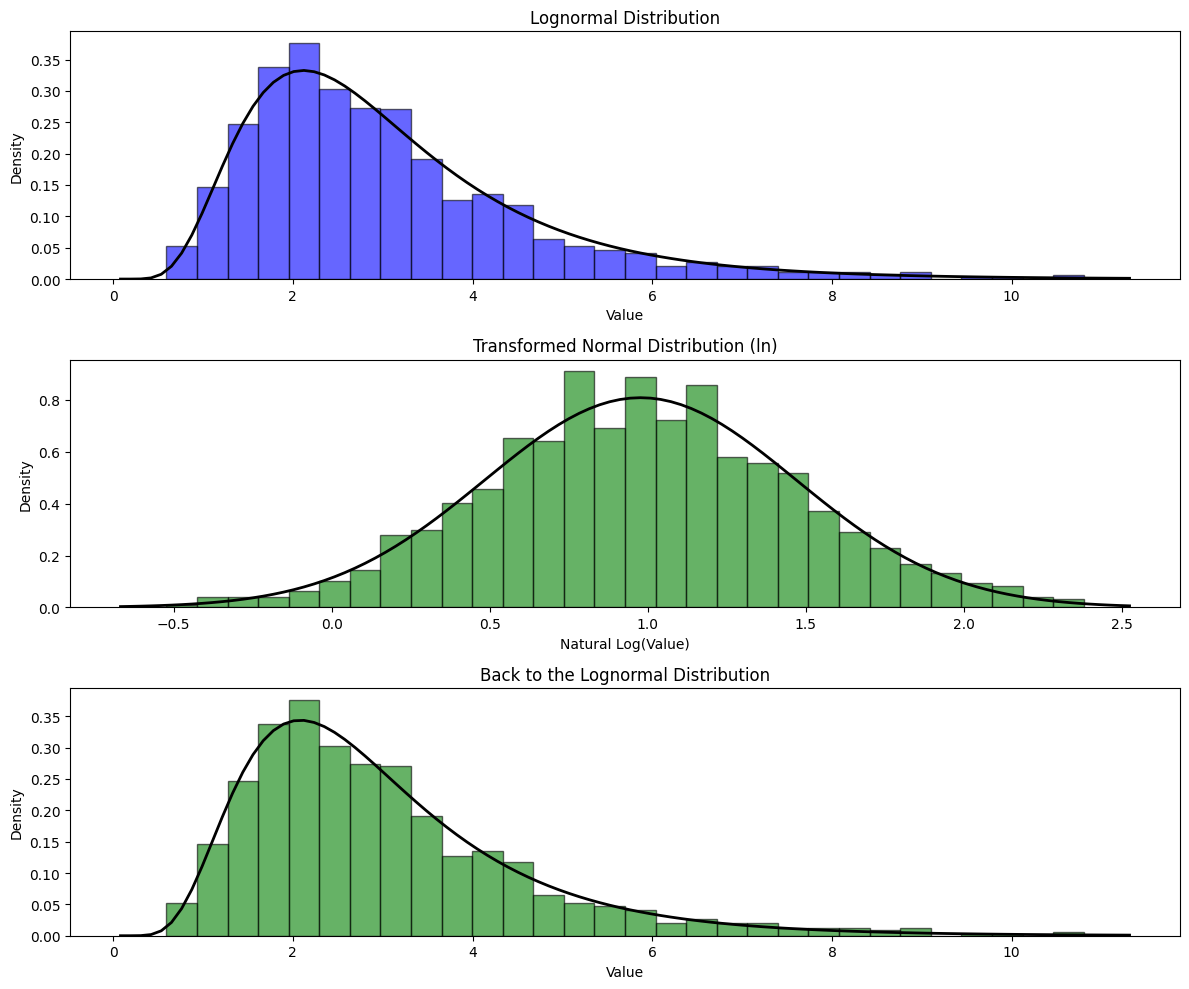

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, lognorm

# Step 1: Generate a lognormal distribution
np.random.seed(0)  # For reproducibility
mean_log = 1.0  # Mean of the underlying normal distribution (log scale)
std_log = 0.5  # Standard deviation of the underlying normal distribution (log scale)
size = 1000    # Number of samples

# Generate lognormal data
lognormal_data = np.random.lognormal(mean_log, std_log, size)

# Step 2: Transform to a normal distribution using natural log
log_transformed_data = np.log(lognormal_data)

# Compute the mean and standard deviation of the transformed data (normal distribution)
mean_transformed = np.mean(log_transformed_data)
std_transformed = np.std(log_transformed_data)

# Step 3: Retrieve the mean, mode, and standard deviation of the original lognormal distribution
# For natural log transformation
mean_lognormal_from_transformed = np.exp(mean_transformed + 0.5 * std_transformed**2)
mode_lognormal_from_transformed = np.exp(mean_transformed - std_transformed**2)
std_lognormal_from_transformed = np.sqrt((np.exp(std_transformed**2) - 1) * np.exp(2 * mean_transformed + std_transformed**2))

# Step 4: Calculate mean, mode, and standard deviation directly from the original lognormal data
mean_lognormal_direct = np.mean(lognormal_data)
mode_lognormal_direct = np.exp(mean_log - std_log**2)  # Mode formula for lognormal distribution
std_lognormal_direct = np.std(lognormal_data)

# Step 5: Transform back the normal distribution to the lognormal one using exp
back_to_lognormal_data = np.exp(log_transformed_data)

# Print the results
print("Transformed Normal Distribution:")
print(f"Mean (ln): {mean_transformed:.5f}")
print(f"Standard Deviation (ln): {std_transformed:.5f}")

print("\nLognormal Distribution Derived from Transformed Normal:")
print(f"Mean: {mean_lognormal_from_transformed:.5f}")
print(f"Mode: {mode_lognormal_from_transformed:.5f}")
print(f"Standard Deviation: {std_lognormal_from_transformed:.5f}")

print("\nDirect Calculation from Original Lognormal Distribution:")
print(f"Mean: {mean_lognormal_direct:.5f}")
print(f"Mode: {mode_lognormal_direct:.5f}")
print(f"Standard Deviation: {std_lognormal_direct:.5f}")

# Plot the original lognormal and transformed normal distributions
fig, ax = plt.subplots(3, 1, figsize=(12, 10))

# Original Lognormal Distribution
ax[0].hist(lognormal_data, bins=30, density=True, alpha=0.6, color='blue', edgecolor='black')
xmin, xmax = ax[0].get_xlim()
x = np.linspace(xmin, xmax, 100)
p = lognorm.pdf(x, std_log, scale=np.exp(mean_log))
ax[0].plot(x, p, 'k', linewidth=2)
ax[0].set_title('Lognormal Distribution')
ax[0].set_xlabel('Value')
ax[0].set_ylabel('Density')

# Transformed Normal Distribution
ax[1].hist(log_transformed_data, bins=30, density=True, alpha=0.6, color='green', edgecolor='black')
xmin, xmax = ax[1].get_xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mean_transformed, std_transformed)
ax[1].plot(x, p, 'k', linewidth=2)
ax[1].set_title('Transformed Normal Distribution (ln)')
ax[1].set_xlabel('Natural Log(Value)')
ax[1].set_ylabel('Density')

#  Logormal Distribution From the Normal one
ax[2].hist(back_to_lognormal_data, bins=30, density=True, alpha=0.6, color='green', edgecolor='black')
xmin, xmax = ax[2].get_xlim()
x = np.linspace(xmin, xmax, 100)
p = lognorm.pdf(x, np.std(np.log(back_to_lognormal_data)), scale=np.exp(np.mean(np.log(back_to_lognormal_data))))
ax[2].plot(x, p, 'k', linewidth=2)
ax[2].set_title('Back to the Lognormal Distribution')
ax[2].set_xlabel('Value')
ax[2].set_ylabel('Density')

plt.tight_layout()
plt.show()


### Minimum Variances Unbiased Estimator (MVUE) - da verificare 
form 10.1016/j.ijggc.2016.02.012

In [10]:
import PyCO2stats as PyCO2
import numpy as np


# Example usage
data = np.random.lognormal(mean=1, sigma=0.5, size=1000)

mvue_mean, mvue_ci_lower, mvue_ci_upper  = PyCO2.Stats.mvue_lnorm_dist(data, confidence=0.95, sighel="chatGPT")

print(f"MVUE Mean: {mvue_mean:.5f}")
print(f"95% Confidence Interval: {mvue_ci_lower}, {mvue_ci_upper}")

mvue_mean, mvue_ci_lower, mvue_ci_upper  = PyCO2.Stats.mvue_lnorm_dist(data, confidence=0.95, sighel="MP")

print(f"MVUE Mean: {mvue_mean:.5f}")
print(f"95% Confidence Interval: {mvue_ci_lower}, {mvue_ci_upper}")


ModuleNotFoundError: No module named 'PyCO2stats'

In [ ]:
import numpy as np
import scipy.stats as stats
import scipy.special as sp

def sichel_function(sigma_sq, n, max_terms=15, tol=1e-10):
    """Compute Sichel's function ψ_n using logarithmic space for stability."""
    psi_n = 1 + (n - 1) / n * sigma_sq  # Start with the first two terms

    for j in range(2, max_terms + 1):
        # Calculate the logarithm of the numerator and denominator
        log_numerator = (2 * j - 1) * np.log(n - 1)
        log_denominator = j * np.log(n) + np.sum(np.log(np.arange(n + 1, n + 2 * j, 2)))
        
        # Compute the term in logarithmic space
        log_term = log_numerator - log_denominator + j * np.log(sigma_sq) - sp.gammaln(j + 1)
        
        # Convert back to original space
        term = np.exp(log_term)
        
        psi_n += term
        
        # Break if the term is very small
        if term < tol:
            break
    
    return psi_n

def mvue_lognormal(data, confidence=0.95):
    """
    Calculate the MVUE for the mean and confidence interval for log-normally distributed data using Sichel's function.
    
    Parameters:
    data (array-like): Log-normally distributed data.
    confidence (float): Confidence level for the interval. Default is 0.95.
    
    Returns:
    dict: A dictionary containing the MVUE mean and confidence interval.
    """
    # Step 1: Transform the data using the natural log
    log_data = np.log(data)
    
    # Step 2: Calculate the sample mean and variance of the log-transformed data
    n = len(log_data)
    sample_mean_log = np.mean(log_data)
    sample_variance_log = np.var(log_data, ddof=1)  # Using unbiased estimator with ddof=1
    
    # Step 3: Calculate Sichel's function ψ_n
    psi_n = sichel_function(0.5 * sample_variance_log, n)
    
    # Step 4: Estimate the mean of the log-normal distribution using MVUE
    mvue_mean = np.exp(sample_mean_log) * psi_n
    
    # Step 5: Calculate the confidence interval for the mean of the log-normal distribution
    t_alpha_2 = stats.t.ppf(1 - (1 - confidence) / 2, df=n-1)
    ci_lower_log = sample_mean_log - t_alpha_2 * np.sqrt(sample_variance_log / n)
    ci_upper_log = sample_mean_log + t_alpha_2 * np.sqrt(sample_variance_log / n)
    
    mvue_ci_lower = np.exp(ci_lower_log) * psi_n
    mvue_ci_upper = np.exp(ci_upper_log) * psi_n
    
    return {
        'MVUE Mean': mvue_mean,
        'Confidence Interval': (mvue_ci_lower, mvue_ci_upper)
    }


result = mvue_lognormal(data, confidence=0.95)
print(f"MVUE Mean: {result['MVUE Mean']:.5f}")
print(f"95% Confidence Interval: {result['Confidence Interval']}")


## Sigma Clipping

In [ ]:
import PyCO2stats as PyCO2
import numpy as np
import scipy.stats as stats
from astropy.stats import sigma_clipped_stats

rng = np.random.default_rng(0)
x = np.arange(200)
y = np.zeros(200)
c = stats.bernoulli.rvs(0.35, size=x.shape)
y += (rng.normal(0., 0.2, x.shape) + c * rng.normal(3.0, 5.0, x.shape))

sigma_clipped_statistics = sigma_clipped_stats(y, sigma=3, maxiters=10) 
print(sigma_clipped_statistics)
my_sigma_clipped_statistics = PyCO2.Stats.sigma_clipped_stats(y, sigma=3, maxiters=10) 
print(my_sigma_clipped_statistics)


### Biweight location

In [ ]:
from astropy.stats import biweight_location

biweight_loc = biweight_location(y) 
print(biweight_loc)
my_biweight_loc = PyCO2.Stats.biweight_location(y)  
print(my_biweight_loc)

In [ ]:
import scipy as sp
sp.__version__

In [ ]:
import PyCO2stats as PyCO2
import numpy as np
from scipy.stats import *
from astropy.stats import *
from scipy.stats.mstats import *
import statsmodels.api as sm


# Test the functions on lognormal distribution with added noise
np.random.seed(0)
data = np.random.lognormal(mean=0, sigma=1, size=1000)
noise = np.random.normal(0, 0.1, 1000)
data_with_noise = data + noise

# Testing Stats functions
print("Testing Stats functions with data_with_noise")

# Sample from PDF
x = np.linspace(min(data_with_noise), max(data_with_noise), 1000)
pdf = lognorm.pdf(x, s=1, scale=np.exp(0))
sampled_data = PyCO2.Stats.sample_from_pdf(x, pdf)
print("Sample from PDF:", sampled_data[:5])

# MVUE for log-normal distribution
mvue_mean, mvue_ci_lower, mvue_ci_upper = PyCO2.Stats.mvue_lnorm_dist(data_with_noise)
print("MVUE mean:", mvue_mean)
print("MVUE CI lower:", mvue_ci_lower)
print("MVUE CI upper:", mvue_ci_upper)

# Median
median = PyCO2.Stats.median(data_with_noise)
print("Median:", median)

# Median Absolute Deviation
mad = PyCO2.Stats.median_absolute_deviation(data_with_noise)
print("MAD:", mad)

# MAD standard deviation
my_mad_std = PyCO2.Stats.mad_std(data_with_noise)
print("MAD Std:", my_mad_std)

# Sigma clipping
sigma_clipped_data = PyCO2.Stats.sigma_clip(data_with_noise)
print("Sigma clipped data:", sigma_clipped_data[:5])

# Sigma clipped statistics
mean, median, stddev = PyCO2.Stats.sigma_clipped_stats(data_with_noise)
print("Sigma clipped stats - mean:", mean)
print("Sigma clipped stats - median:", median)
print("Sigma clipped stats - stddev:", stddev)

# Biweight location
biweight_loc = PyCO2.Stats.biweight_location(data_with_noise)
print("Biweight location:", biweight_loc)

# Biweight scale
biweight_scl = PyCO2.Stats.biweight_scale(data_with_noise)
print("Biweight scale:", biweight_scl)

# Trim
trimmed_data = PyCO2.Stats.trim(data_with_noise)
print("Trimmed data:", trimmed_data[:5])

# Trimmed mean
trimmed_mean = PyCO2.Stats.trimmed_mean(data_with_noise)
print("Trimmed mean:", trimmed_mean)

# Trimmed std
my_trimmed_std = PyCO2.Stats.trimmed_std(data_with_noise)
print("Trimmed std:", my_trimmed_std)

# Trim both
trimboth_data = PyCO2.Stats.trimboth(data_with_noise,proportiontocut=0.1)
print("Trim both data:", trimboth_data[:5])

# Trim tail
trimtail_data = PyCO2.Stats.trimtail(data_with_noise)
print("Trim tail data:", trimtail_data[:5])

# Winsorize
winsorized_data = PyCO2.Stats.winsorize(data_with_noise)
print("Winsorized data:", winsorized_data[:5])

# Winsorized mean
winsorized_mean = PyCO2.Stats.winsorized_mean(data_with_noise)
print("Winsorized mean:", winsorized_mean)

# Winsorized std
winsorized_std = PyCO2.Stats.winsorized_std(data_with_noise)
print("Winsorized std:", winsorized_std)

# Huber
huber_loc, huber_scl = PyCO2.Stats.Huber(data_with_noise)
print("Huber location:", huber_loc)
print("Huber scale:", huber_scl)

# Comparison with original functions
print("\nComparison with original functions")

# Biweight location comparison
biweight_loc_orig = biweight_location(data_with_noise)
print("Original Biweight location:", biweight_loc_orig)

# Biweight scale comparison
biweight_scl_orig = biweight_scale(data_with_noise)
print("Original Biweight scale:", biweight_scl_orig)

# MAD comparison
mad_orig = median_absolute_deviation(data_with_noise)
print("Original MAD:", mad_orig)

# MAD std comparison
mad_std_orig = mad_std(data_with_noise)
print("Original MAD Std:", mad_std_orig)

# Sigma clipping comparison
sigma_clipped_data_orig = sigma_clip(data_with_noise)
print("Original Sigma clipped data:", sigma_clipped_data_orig[:5])

# Sigma clipped stats comparison
mean_orig, median_orig, stddev_orig = sigma_clipped_stats(data_with_noise)
print("Original Sigma clipped stats - mean:", mean_orig)
print("Original Sigma clipped stats - median:", median_orig)
print("Original Sigma clipped stats - stddev:", stddev_orig)

# Trim comparison
trimmed_data_orig = trim(data_with_noise)
print("Original Trimmed data:", trimmed_data_orig[:5])

# Trimmed mean comparison
trimmed_mean_orig = tmean(data_with_noise)
print("Original Trimmed mean:", trimmed_mean_orig)

# Trimmed std comparison
trimmed_std_orig = trimmed_std(data_with_noise)
print("Original Trimmed std:", trimmed_std_orig)

# Trim both comparison
trimboth_data_orig = trimboth(data_with_noise)
print("Original Trim both data:", trimboth_data_orig[:5])

# Trim tail comparison
trimtail_data_orig = trimtail(data_with_noise)
print("Original Trim tail data:", trimtail_data_orig[:5])

# Winsorize comparison
winsorized_data_orig = winsorize(data_with_noise)
print("Original Winsorized data:", winsorized_data_orig[:5])

# Winsorized mean comparison
winsorized_mean_orig = np.mean(winsorize(data_with_noise))
print("Original Winsorized mean:", winsorized_mean_orig)

# Winsorized std comparison

winsorized_std_orig = np.std(winsorize(data_with_noise))
print("Original Winsorized std:", winsorized_std_orig)

# Huber comparison
huber_proposal_2 = sm.robust.Huber()
huber_loc_orig, huber_scl_orig = huber_proposal_2(data_with_noise)
print("Original Huber location:", huber_loc_orig)
print("Original Huber scale:", huber_scl_orig)